# BAYSIAN ARMA vs CLASSIC ARMA

## NUMBER OF AIR  PASSENGERS OVER THE YEARS (1949 - 1960)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 
%matplotlib.pylab as plt 
from matplotlib.pylab import rcParams 
rcParam['figure.figsize'] = 15, 10 
from datetime import datetime

UsageError: Line magic function `%matplotlib.pylab` not found.


# Importing Data

We start by uploading the data set from the following csv file: "AirPassengers.csv". Next we set the dates as the index of the data set.

In [2]:
dataset = pd.read_csv(r"C:\Users\ahmed\Downloads\archive (1)\AirPassengers.csv")
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format = True)
indexedDataset = dataset.set_index(['Month'])


Here's a simple plot of the data set. 

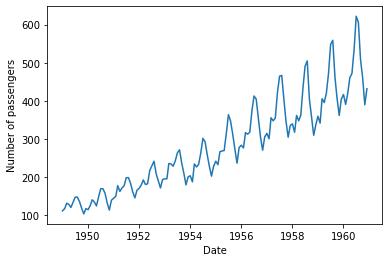

In [3]:
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.plot(indexedDataset)

# Stationarity

To test the sationarity of the data set we use the following two methods: 

1- plotting the rolling mean and standard deviation

2- performing Dickey-Fuller test and checking if the p-value is below <0.05

In [5]:
from statsmodels.tsa.stattools import adfuller 
def testing_stationarity(dataset):
    rolling_mean = dataset.rolling(window=12).mean()
    rolling_std = dataset.rolling(window=12).std()
    
    #Plotting rolling mean and std
    original_data = plt.plot(dataset, color = 'black', label='Original')
    mean = plt.plot(rolling_mean, color = 'red', label='Rolling mean')
    std = plt.plot(rolling_std , color = 'blue', label='Rolling std')
    plt.legend(loc="best")
    plt.title(' Rolling mean and std')
    plt.show()
    
    #Dickey-fuller test
    print('Dickey-Fuller test results: ')
    dftest = adfuller(dataset['#Passengers'], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value ' + str(k)] = v
    print(dfoutput)

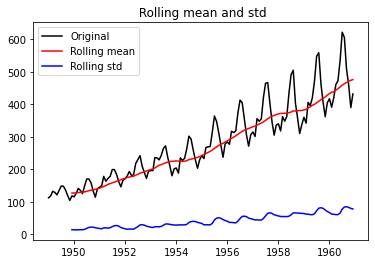

Dickey-Fuller test results: 
Test Statistic                   0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [6]:
testing_stationarity(indexedDataset)

Based on the plotting of the rolling mean and standard diviation seen above, we deduce that the rolling mean and standard deviation are clearly not stationary (upward trend). In addition, by performing the Dickey-Fuller test we obtain a p-value that is significantly greater than 0.05. We thus conclude that the dataset is non-stationary.

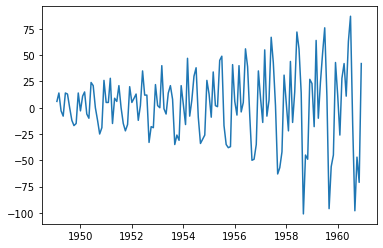

In [10]:
difference_1 = indexedDataset - indexedDataset.shift()
difference_1.dropna(inplace=True)
plt.plot(difference_1)

A common approach to deal with non-stationarity of the data is to analyse the difference between two consecutive data points. In other words we study the differencing of the data. 

We now study the stationarity of the transformed data set":

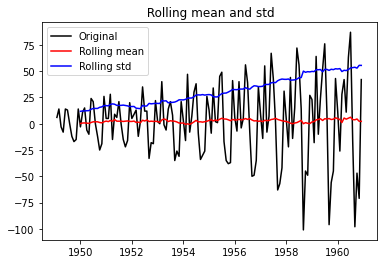

Dickey-Fuller test results: 
Test Statistic                  -2.829267
p-value                          0.054213
Lags Used                       12.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [11]:
testing_stationarity(difference_1)

Based on the plotting of the rolling mean and standard diviation seen above, we deduce that the rolling mean is relatively constant over time.  However the standard deviation still shows a non stationary behavior by having a slight upward trend. Furthermore, by performing the Dickey-Fuller test we obtain a p-value that is almost equal to 0.05. Despite having a variance that is getting greater over time we can still consider that the data is stationary based on the rolling mean plot and the Dickey-Fuller test results (seen above).

# Model Parameters

### Seasonality

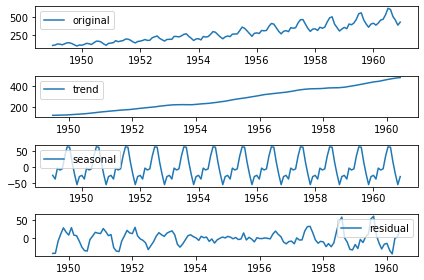

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

Decomposition = seasonal_decompose(indexedDataset)

trend = Decomposition.trend
seasonal = Decomposition.seasonal
residual = Decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset, label = "original")
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = "trend")
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = "seasonal")
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = "residual")
plt.legend(loc = 'best')
plt.tight_layout()

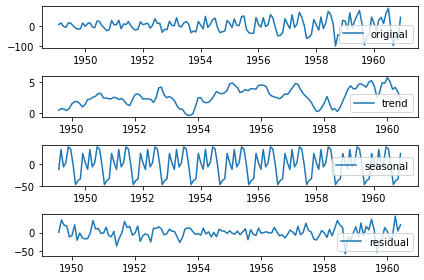

In [15]:
Decomposition = seasonal_decompose(difference_1)

trend = Decomposition.trend
seasonal = Decomposition.seasonal
residual = Decomposition.resid

plt.subplot(411)
plt.plot(difference_1, label = "original")
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = "trend")
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = "seasonal")
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = "residual")
plt.legend(loc = 'best')
plt.tight_layout()

Based on the seasonal decomposition plot seen above we observe a significant seasonality in the data. The data follows a similar pattern every six time steps (6 months). We thus conclude that the seasonality interval k = 6. 


### Moving Average Parameter

c:\users\ahmed\miniconda3\envs\ai_env\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


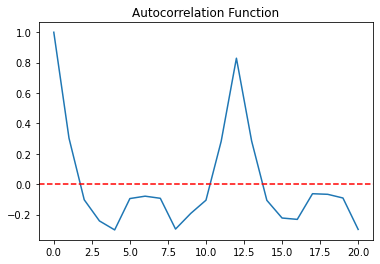

In [17]:
from statsmodels.tsa.stattools import acf

acf = acf(difference_1, nlags = 20 )

plt.plot(acf) 
plt.axhline(y=0, linestyle = '--', color='red')
plt.title('Autocorrelation Function')
plt.show()

<BarContainer object of 20 artists>

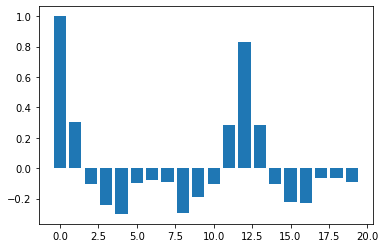

In [152]:
plt.bar(range(20), acf[:20])

Based on the ACF function we pick p=2.

### Autoregressive Parameter

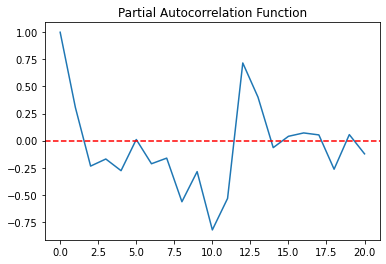

In [20]:
from statsmodels.tsa.stattools import  pacf

pacf = pacf(difference_1, nlags = 20, method = 'ols')

plt.plot(pacf) 
plt.axhline(y=0, linestyle = '--', color='red')
plt.title('Partial Autocorrelation Function')
plt.show()

<BarContainer object of 20 artists>

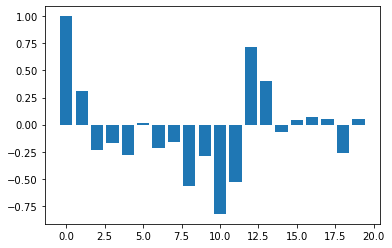

In [153]:
plt.bar(range(20), pacf[:20])

In [ ]:
Based on the PACF function we pick q=2.

# Model  Fitting 

We split the dataset in two sets: a training set that will be used to fit our ARMA model and a testing set that will allow us to test our fitted model. 

In [130]:
training_set = indexedDataset.iloc[0:138]
test_set = indexedDataset.iloc[137:143]

In [131]:
difference_test_set = difference_1.iloc[137:143]
difference_training_set = difference_1.iloc[0:137]

c:\users\ahmed\miniconda3\envs\ai_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\ahmed\miniconda3\envs\ai_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, s

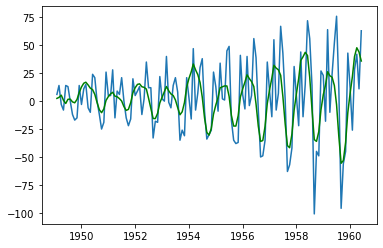

In [213]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(difference_training_set, order = (2, 2))
results = model.fit()
plt.plot(difference_training_set)
plt.plot(results.fittedvalues, color = 'green')

# Model Predictions  

### CLASSIC ARIMA

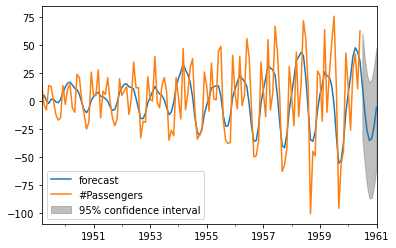

In [214]:
results.plot_predict(1, 143)
predictions = results.forecast(steps = 6)

In [215]:
predictions

(array([ 13.67784659,  -8.92743229, -26.66161277, -35.30512233,
        -33.36662046, -22.24271179]),
 array([23.96022888, 24.41289371, 25.43118011, 26.51507759, 27.16187621,
        27.31394947]),
 array([[-33.28333907,  60.63903226],
        [-56.77582472,  38.92096013],
        [-76.50580988,  23.18258433],
        [-87.27371945,  16.66347479],
        [-86.60291959,  19.86967866],
        [-75.77706903,  31.29164544]]))

### BAYESIAN ARIMA (using OpenBUGS)

We import the predicted value of the WinBUGS model from a the following csv file: "".

In [228]:
winBugs_results = pd.read_csv(r"C:\Users\ahmed\Downloads\archive (1)\Book1.csv")
winBugs_results['Month'] = pd.to_datetime(winBugs_results['Month'], infer_datetime_format = True)
winBugs_results = winBugs_results.set_index(['Month'])


In [229]:
winBugs_results

,#Passengers
Month,
1960-07-01,71.88
1960-08-01,11.88
1960-09-01,-98.91
1960-10-01,-52.93
1960-11-01,-46.43
1960-12-01,37.74


# Model Comparison

Finally, we compare the performance of the BAYSIAN ARMA(2,2) and CLASSIC ARMA(2,2) on the testing set using the Risidual Standard Error (RSS).

In [235]:
classic_results = winBugs_results.copy()
for i in range(len(classic_results)):
    classic_results['#Passengers'][i] = predictions[0][i]
    

In [243]:
print(f"Here's the forcasted values:\n")
print(classic_results)
print("")
print("RSS: ", sum((classic_results['#Passengers'] - difference_test_set['#Passengers'])**2))

Here's the forcasted values:

            #Passengers
Month                  
1960-07-01    13.677847
1960-08-01    -8.927432
1960-09-01   -26.661613
1960-10-01   -35.305122
1960-11-01   -33.366620
1960-12-01   -22.242712

RSS:  16195.492323785733


In [244]:
print(f"Here's the forcasted values:\n")
print(winBugs_results)
print("")
print("RSS: ", sum((winBugs_results['#Passengers'] - difference_test_set['#Passengers'])**2))

Here's the forcasted values:

            #Passengers
Month                  
1960-07-01        71.88
1960-08-01        11.88
1960-09-01       -98.91
1960-10-01       -52.93
1960-11-01       -46.43
1960-12-01        37.74

RSS:  1663.7343000000003


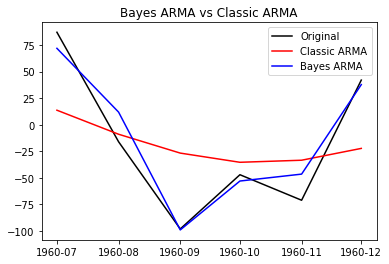

CLASSIC ARMA MODEL
RSS:  16195.492323785733

BAYESIAN ARMA MODEL
RSS:  1663.7343000000003


In [246]:
original_data = plt.plot(difference_test_set, color = 'black', label='Original')
mean = plt.plot(classic_results, color = 'red', label='Classic ARMA')
std = plt.plot(winBugs_results , color = 'blue', label='Bayes ARMA')
plt.legend(loc="best")
plt.title('Bayes ARMA vs Classic ARMA')
plt.show()

print("CLASSIC ARMA MODEL")
print("RSS: ", sum((classic_results['#Passengers'] - difference_test_set['#Passengers'])**2))

print(f"\nBAYESIAN ARMA MODEL")
print("RSS: ", sum((winBugs_results['#Passengers'] - difference_test_set['#Passengers'])**2))
